# X Degrees of Separation
What is the connection between a 4000 year old clay figure and Van Gogh's Starry Night? How do you get from Bruegel's Tower of Babel to the street art of Rio de Janeiro? What links an African mask to a Japanese wood cut?

The following notebook implelements Google's [X Degrees of Separation](https://artsexperiments.withgoogle.com/xdegrees/) project in pytorch using images from [WikiArt](https://www.wikiart.org/). The basic idea is to find the shortest path between two images.

Example of WikiArt datasets that can be used for this task [link1](http://saifmohammad.com/WebPages/wikiartemotions.html) [link2](https://github.com/cs-chan/ArtGAN/tree/master/WikiArt%20Dataset)


<table class="tfo-notebook-buttons" align="left"><td>
<a target="_blank"  href="https://colab.research.google.com/github/dzlab/deepprojects/blob/master/artistic/X_degrees_of_separation_pytorch.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank"  href="https://github.com/dzlab/deepprojects/blob/master/artistic/X_degrees_of_separation_pytorch.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

### Dependencies

install a fast lib for calculating kNNs

In [4]:
!pip install nmslib

    100% |████████████████████████████████| 256kB 7.4MB/s 
    100% |████████████████████████████████| 153kB 31.1MB/s 
  Failed building wheel for nmslib
  Running setup.py clean for nmslib
Failed to build nmslib
  Running setup.py install for nmslib ... done


install a fast lib for calculting PCAs on extracted image features [FBPCA](https://github.com/facebook/fbpca).

In [40]:
!pip install fbpca

  Stored in directory: /root/.cache/pip/wheels/53/a2/dd/9b66cf53dbc58cec1e613d216689e5fa946d3e7805c30f60dc
Successfully built fbpca


install Graph analysis library [iGraph](https://igraph.org/python/).

In [78]:
!pip install python-igraph

    100% |████████████████████████████████| 378kB 25.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/41/d6/02/34eebae97e25f5b87d60f4c0687e00523e3f244fa41bc3f4a7
Successfully built python-igraph


### Imports

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_notebook
import io
import pathlib
import collections
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
from random import randint
import pickle
import urllib

## Data
Download a subset of wikiart images

### WikiArt Metadata

In [11]:
!curl -O http://saifmohammad.com/WebDocs/WikiArt-Emotions.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0 2416k    0 14254    0     0  36642      0  0:01:07 --:--:--  0:01:07 36548^C


In [2]:
!unzip WikiArt-Emotions.zip

Archive:  WikiArt-Emotions.zip
   creating: WikiArt-Emotions/
  inflating: WikiArt-Emotions/WikiArt-Emotions-All.tsv  
   creating: __MACOSX/
   creating: __MACOSX/WikiArt-Emotions/
  inflating: __MACOSX/WikiArt-Emotions/._WikiArt-Emotions-All.tsv  
  inflating: WikiArt-Emotions/WikiArt-annotations.csv  
  inflating: __MACOSX/WikiArt-Emotions/._WikiArt-annotations.csv  
  inflating: WikiArt-Emotions/WikiArt-info.tsv  
  inflating: __MACOSX/WikiArt-Emotions/._WikiArt-info.tsv  
  inflating: WikiArt-Emotions/README.txt  
  inflating: __MACOSX/WikiArt-Emotions/._README.txt  
  inflating: WikiArt-Emotions/WikiArt-Emotions-Ag5.tsv  
  inflating: __MACOSX/WikiArt-Emotions/._WikiArt-Emotions-Ag5.tsv  
  inflating: WikiArt-Emotions/WikiArt-Emotions-Ag4.tsv  
  inflating: __MACOSX/WikiArt-Emotions/._WikiArt-Emotions-Ag4.tsv  
  inflating: WikiArt-Emotions/WikiArt-Emotions-Ag3.tsv  
  inflating: __MACOSX/WikiArt-Emotions/._WikiArt-Emotions-Ag3.tsv  


In [0]:
PATH = pathlib.Path('WikiArt-Emotions')

In [6]:
df = pd.read_csv(PATH/'WikiArt-Emotions-Ag4.tsv', delimiter='\t'); df.head()

ID                 Style            Category  \
0  58c6237dedc2c9c7dc0de1ae            Modern Art       Impressionism   
1  577280dfedc2cb3880f28e76            Modern Art   Neo-Expressionism   
2  57727f2dedc2cb3880ed5fa9            Modern Art  Post-Impressionism   
3  58d1240cedc2c94f900fc610            Modern Art              Cubism   
4  57727de7edc2cb3880e91f26  Post Renaissance Art         Romanticism   

                    Artist                                          Title  \
0  Charles Courtney Curran                       In the Luxembourg Garden   
1             Keith Haring                The Marriage of Heaven and Hell   
2       Jozsef Rippl-Ronai  Uncle Piacsek in front of the Black Sideboard   
3             Vadym Meller           Monk. For the Play &#39;Mazeppa&#39;   
4             David Wilkie                   The Defence of Sarago&#231;a   

   Year                                          Image URL  \
0  1889  https://use2-uploads3.wikiart.org/00123/images...   
1  1984  https://use2-uploads1.wikiart.org/images/keith...   
2  1906  https://use2-uploads3.wikiart.org/images/j-zse...   
3  1920  https://use2-uploads2.wikiart.org/00124/images...   
4  1828  https://use2-uploads6.wikiart.org/images/david...   

                                   Painting Info URL  \
0  https://www.wikiart.org/en/charles-courtney-cu...   
1  https://www.wikiart.org/en/keith-haring/the-ma...   
2  https://www.wikiart.org/en/jozsef-rippl-ronai/...   
3  https://www.wikiart.org/en/vadym-meller/monk-f...   
4  https://www.wikiart.org/en/david-wilkie/the-de...   

                                     Artist Info URL Is painting  \
0  https://www.wikiart.org/en/charles-courtney-cu...         yes   
1            https://www.wikiart.org/en/keith-haring         yes   
2      https://www.wikiart.org/en/jozsef-rippl-ronai         yes   
3            https://www.wikiart.org/en/vadym-meller         yes   
4            https://www.wikiart.org/en/david-wilkie         yes   

          ...         TitleOnly: love  TitleOnly: optimism  \
0         ...                       0                    0   
1         ...                       0                    0   
2         ...                       0                    0   
3         ...                       0                    0   
4         ...                       0                    0   

   TitleOnly: pessimism  TitleOnly: regret  TitleOnly: sadness  \
0                     0                  0                   0   
1                     0                  0                   0   
2                     0                  0                   0   
3                     0                  0                   0   
4                     0                  0                   0   

   TitleOnly: shame  TitleOnly: shyness  TitleOnly: surprise  \
0                 0                   0                    0   
1                 0                   0                    0   
2                 0                   0                    0   
3                 0                   0                    0   
4                 0                   0                    0   

   TitleOnly: trust  TitleOnly: neutral  
0                 0                   0  
1                 0                   0  
2                 0                   0  
3                 0                   0  
4                 0                   0  

[5 rows x 72 columns]

In [7]:
urls = df['Image URL'].tolist(); urls[:5]

['https://use2-uploads3.wikiart.org/00123/images/charles-courtney-curran/in-the-luxembourg-garden-1889.jpg',
 'https://use2-uploads1.wikiart.org/images/keith-haring/the-marriage-of-heaven-and-hell-1984.jpg',
 'https://use2-uploads3.wikiart.org/images/j-zsef-rippl-r-nai/uncle-piacsek-in-front-of-the-black-sideboard-1906.jpg',
 'https://use2-uploads2.wikiart.org/00124/images/vadym-meller/monk-for-the-play-mazeppa-1920.jpg',
 'https://use2-uploads6.wikiart.org/images/david-wilkie/the-defence-of-sarago-a.jpg']

### WikiArt images
download the images using the URLs in the metadata files like `WikiArt-Emotions-Ag4.tsv`.

In [0]:
images_path = PATH/'images'
images_path.mkdir(parents=True, exist_ok=True)

ignore SSL erros like *CERTIFICATE_VERIFY_FAILED*

In [0]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [0]:
def download(path, urls):
    for url in tqdm(urls):
        fname = url[url.rfind('/')+1:]
        urllib.request.urlretrieve(url, path/fname)

In [27]:
download(images_path, urls)

100%|██████████| 4105/4105 [2:12:03<00:00,  1.92s/it]


display a random set of the downloaded images

In [0]:
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

In [0]:
imspaths = [images_path/(url[url.rfind('/')+1:]) for url in urls]
titles = [imspath.stem for imspath in imspaths]

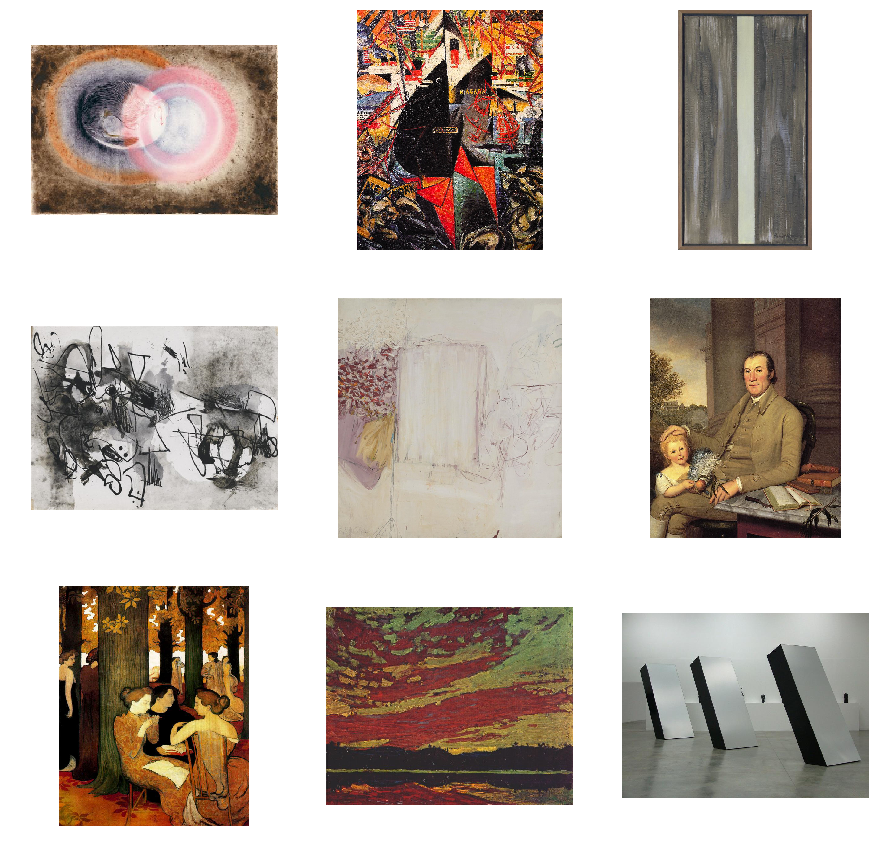

In [13]:
max_index = len(imspaths) - 1
random_imspaths = [imspaths[np.random.randint(0, max_index)] for i in range(9)]
plots_from_files(random_imspaths, figsize=(15, 15), rows=3)

## Feature extraction
Extract the feature form those images to use it later to calculate distance between images

### Pre-Trained ResNet model

In [0]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets

In [0]:
# batch size
bs = 48
# image size
sz = 128

In [0]:
model = models.resnet18(pretrained=True)

get a feature extractor from the backbone imagenet classifier

In [0]:
feature_modules = list(model.children())[:-2]
feature_extractor = nn.Sequential(*feature_modules)

In [0]:
tfrms = transforms.Compose([
        transforms.Resize((sz, sz)),
        #transforms.RandomSizedCrop(sz),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [0]:
ds = datasets.ImageFolder(root=str(PATH), transform=tfrms)
dl = torch.utils.data.DataLoader(ds, batch_size=bs, shuffle=False, num_workers=4, pin_memory=True)

In [0]:
def generate_features(feature_extractor, dataset, dataloader, features_path=None, features_by_fname=None):
    # get the list of image filenames
    paths = dataset.imgs
    classes = dataset.classes
    # get the index to class dictionnary
    idx_to_class = {}
    for clss in ds.class_to_idx:
        idx_to_class[ds.class_to_idx[clss]] = clss
    # index over the filenames
    index = 0
    # for every batch in the DataLoader
    for batch in tqdm(dataloader):
        # get the input (we don't need the labels)
        X, y = batch
        # run the model to get the image features
        preds = feature_extractor(X)
        # preds shape is: batch_size, 512, 4, 4 (i.e. output of the last BatchNorm layer)
        # avergare over the the last two dimensions
        features_batch = preds.mean(-1).mean(-1)
        for features in features_batch:
            image_path = pathlib.Path(paths[index][0])
            # append features to output
            if features_by_fname != None:
                image_name = image_path.name
                features_by_fname[image_name] = features
            # save the features as .pkl
            if features_path != None:
                feathures_name = image_path.stem + '.pkl'
                torch.save(features, features_path/feathures_name)
            # next index
            index += 1

In [0]:
# create a folder to store generated features
features_path = PATH/'features'
features_path.mkdir(parents=True, exist_ok=True)

In [0]:
import gc
gc.collect()

In [18]:
generate_features(feature_extractor, ds, dl, features_path)

100%|██████████| 84/84 [03:57<00:00,  1.39s/it]


In [17]:
!rm -rf {features_path}/*; ls {features_path} | wc -l

0


### PCA on extracted features
First reduce the dimensionality of feautres using PCA (we will take the eigen vectors).

load raw features

In [23]:
features = []
for fname in tqdm(features_path.glob('*.pkl')):
    feature_arr = torch.load(str(fname)).detach().numpy()
    features.append(feature_arr)

4006it [00:00, 4009.86it/s]


In [43]:
features = np.array(features); features.shape

(4006, 512)

apply PCA

In [0]:
import fbpca
(U, s, Va) = fbpca.pca(features, k=10, raw=True, n_iter=10)

In [0]:
features = U

load the names

In [28]:
names = []
for fname in tqdm(features_path.glob('*.pkl')):
    names.append(fname.stem)

4006it [00:00, 171142.03it/s]


### t-SNE

calculate t-SNE on the engien vectors

In [47]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4006 samples in 0.003s...
[t-SNE] Computed neighbors for 4006 samples in 0.559s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4006
[t-SNE] Computed conditional probabilities for sample 2000 / 4006
[t-SNE] Computed conditional probabilities for sample 3000 / 4006
[t-SNE] Computed conditional probabilities for sample 4000 / 4006
[t-SNE] Computed conditional probabilities for sample 4006 / 4006
[t-SNE] Mean sigma: 0.012460
[t-SNE] Computed conditional probabilities in 0.309s
[t-SNE] Iteration 50: error = 85.7703552, gradient norm = 0.0000000 (50 iterations in 6.127s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 85.770355
[t-SNE] Iteration 100: error = 3.0592186, gradient norm = 0.0018648 (50 iterations in 5.177s)
[t-SNE] Iteration 150: error = 2.7387044, gradient norm = 0.0007329 (50 iterations in 5.207s)
[t-SNE] Iteration 200: error = 2

normalize t-SNE values into the [0, 1] space

In [0]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

visualize the grouping resulting from t-SNE calculation

In [0]:
def get_full_path(img_name):
    """Get the full path of an image by it's name and possible extensions"""
    img_path = images_path/(img_name + '.jpg')
    if not img_path.exists():
        img_path = images_path/(img_name + '.JPG')
    if not img_path.exists():
        img_path = images_path/(img_name + '.png')
    if not img_path.exists():
        img_path = images_path/(img_name + '.jpeg')
    return img_path

def plot_tsne(names, tx, ty, width=4000, height=3000, max_dim=100):
    """Plot tSNE into a big image"""
    full_image = Image.new('RGBA', (width, height))
    for img_name, x, y in zip(names, tx, ty):
        img_path = get_full_path(img_name)    
        tile = Image.open(img_path)
        rs = max(1, tile.width/max_dim, tile.height/max_dim)
        tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
        full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

    plt.figure(figsize = (20,15))
    plt.imshow(full_image)

plot a random subset of the images of size 1k

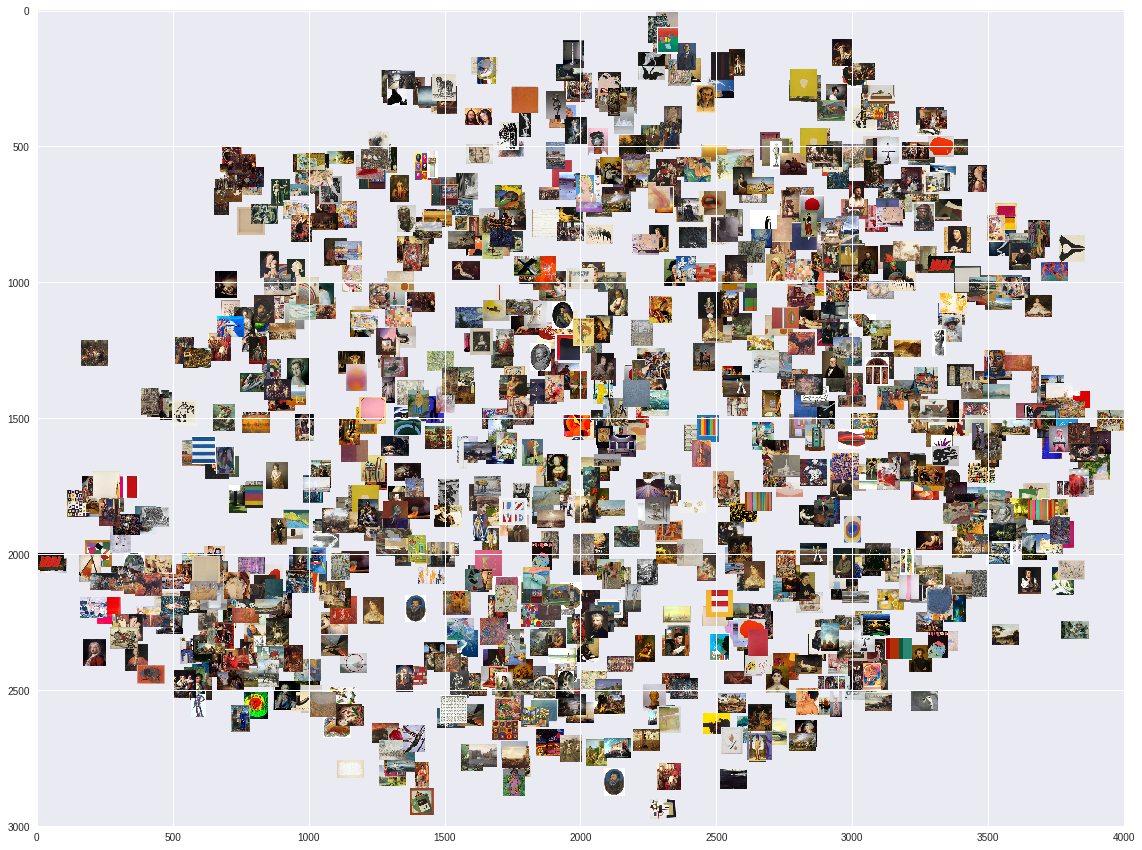

In [65]:
max_index = len(names) - 1
names_1k = [names[np.random.randint(0, max_index)] for i in range(1_000)]
plot_tsne(names_1k, tx, ty)

### kNN on images
Now let's use the extracted features to caclculate the 10 nearest neigborhood for each image

In [24]:
len(features)

4006

In [0]:
import nmslib

def create_index(a):
    # Initializes a new index
    index = nmslib.init(space='angulardist')
    # Add the datapoints to the index
    index.addDataPointBatch(a)
    # Create the index for querying
    index.createIndex()
    return index

def get_knns(index, vecs, k=5):
    """Get approximate K nearest neighbours for each vector in the list"""
    return zip(*index.knnQueryBatch(vecs, k=k, num_threads=4))

def get_knn(index, vec, k=5):
    """Get approximate K nearest neighbours of a vector."""
    return index.knnQuery(vec, k=k)

In [0]:
features_index = create_index(features) # index for nearest neighborhood calculation

for each image calculate it's k=5 kNN

In [0]:
features_nn = get_knns(features_index, features, k=20) # nearest neighborhood on features array

In [0]:
idxs, dists = features_nn

In [39]:
idxs[:5], dists[:5]

((array([   0,  929, 2159, 1210,   16], dtype=int32),
  array([   1, 3668, 1362, 1706,  476], dtype=int32),
  array([   2, 3307,  239, 3967, 3825], dtype=int32),
  array([   3, 1309, 3312, 3069,  901], dtype=int32),
  array([   4, 2140, 2961,  602,  419], dtype=int32)),
 (array([4.8828125e-04, 8.8116568e-01, 8.8147318e-01, 8.9554077e-01,
         8.9840472e-01], dtype=float32),
  array([3.4526698e-04, 8.8191271e-01, 8.9215231e-01, 9.0067762e-01,
         9.1526556e-01], dtype=float32),
  array([4.8828125e-04, 8.3011514e-01, 8.8030827e-01, 8.9467818e-01,
         8.9493918e-01], dtype=float32),
  array([4.8828125e-04, 8.4825307e-01, 8.8931006e-01, 8.9440101e-01,
         9.0227270e-01], dtype=float32),
  array([0.        , 0.86570215, 0.87417823, 0.8755991 , 0.8826365 ],
        dtype=float32)))

### Graph based on kNN

In [0]:
from igraph import *

In [0]:
def create_knn_graph(names, nn_idxs, nn_dists, k=5):
    size = len(names)
    g = Graph()
    # create the vertices
    g.add_vertices(size)
    # create the edges
    for i in range(size):    
        for j in range(1, k):
            g.add_edge(nn_idxs[i][0], nn_idxs[i][j], weight=nn_dists[i][j])
    return g

In [101]:
graph = create_knn_graph(names, idxs, dists, k=20)
summary(graph)

IGRAPH U-W- 4006 76114 -- 
+ attr: weight (e)


helper function to plot images which consititue a path in the previously constructed Graph

In [0]:
def get_concatenated_images(names, indexes, thumb_height):
    """Concatenate the images in the indexes array into a numpy array"""
    thumbs = []
    for idx in indexes:
        img_path = get_full_path(names[idx])
        img = Image.open(img_path)
        img = img.convert('RGB')
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

def display_path(graph, names, src=None, dst=None):
    """Disply a path between two image indices or randomly picked images"""
    size = len(names)
    # pick two random indices
    if not src: src = np.random.randint(0, size)
    if not dst: dst = np.random.randint(0, size)

    # get the shortest path between these vertices
    path = graph.get_shortest_paths(src, to=dst, mode=OUT, output='vpath', weights='weight')[0]

    # retrieve the images, concatenate into one, and display them
    results_image = get_concatenated_images(names, path, 200)
    # disply the path
    plt.figure(figsize = (16,12))
    plt.axis('off')
    plt.imshow(results_image)

path between randmly chosen pictures

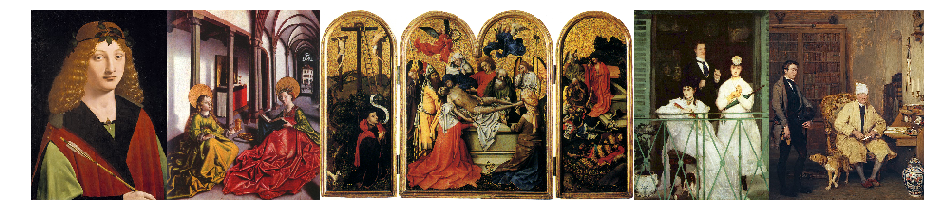

In [103]:
display_path(graph, names)

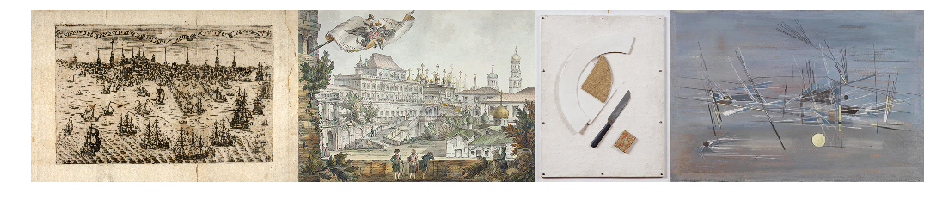

In [108]:
display_path(graph, names)

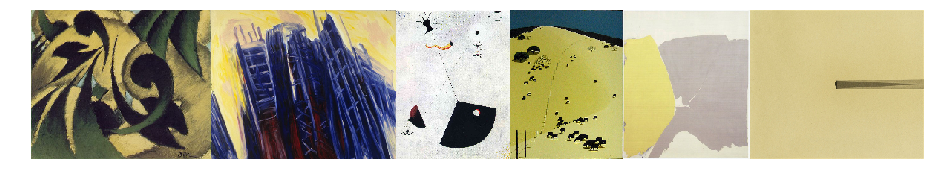

In [105]:
display_path(graph, names)

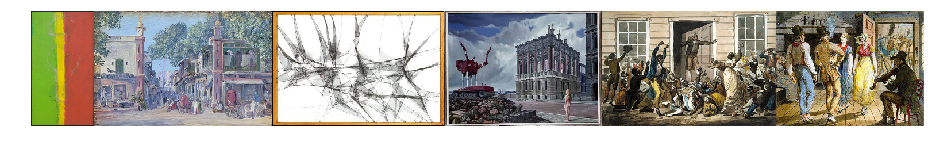

In [106]:
display_path(graph, names, src=1, dst=1000)

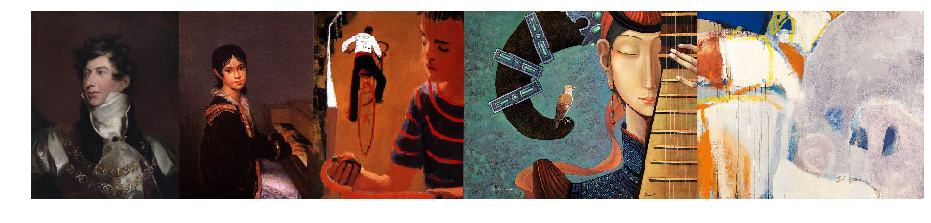

In [109]:
display_path(graph, names, src=50, dst=100)

**The end**.